In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

# Introduction to generative adversarial networks

This notebook contains the second code sample found in Chapter 8, Section 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---
[...]

## A schematic GAN implementation


In what follows, we explain how to implement a GAN in Keras, in its barest form -- since GANs are quite advanced, diving deeply into the 
technical details would be out of scope for us. Our specific implementation will be a deep convolutional GAN, or DCGAN: a GAN where the 
generator and discriminator are deep convnets. In particular, it leverages a `Conv2DTranspose` layer for image upsampling in the generator.

We will train our GAN on images from CIFAR10, a dataset of 50,000 32x32 RGB images belong to 10 classes (5,000 images per class). To make 
things even easier, we will only use images belonging to the class "frog".

Schematically, our GAN looks like this:

* A `generator` network maps vectors of shape `(latent_dim,)` to images of shape `(32, 32, 3)`.
* A `discriminator` network maps images of shape (32, 32, 3) to a binary score estimating the probability that the image is real.
* A `gan` network chains the generator and the discriminator together: `gan(x) = discriminator(generator(x))`. Thus this `gan` network maps 
latent space vectors to the discriminator's assessment of the realism of these latent vectors as decoded by the generator.
* We train the discriminator using examples of real and fake images along with "real"/"fake" labels, as we would train any regular image 
classification model.
* To train the generator, we use the gradients of the generator's weights with regard to the loss of the `gan` model. This means that, at 
every step, we move the weights of the generator in a direction that will make the discriminator more likely to classify as "real" the 
images decoded by the generator. I.e. we train the generator to fool the discriminator.

## A bag of tricks


Training GANs and tuning GAN implementations is notoriously difficult. There are a number of known "tricks" that one should keep in mind. 
Like most things in deep learning, it is more alchemy than science: these tricks are really just heuristics, not theory-backed guidelines. 
They are backed by some level of intuitive understanding of the phenomenon at hand, and they are known to work well empirically, albeit not 
necessarily in every context.

Here are a few of the tricks that we leverage in our own implementation of a GAN generator and discriminator below. It is not an exhaustive 
list of GAN-related tricks; you will find many more across the GAN literature.

* We use `tanh` as the last activation in the generator, instead of `sigmoid`, which would be more commonly found in other types of models.
* We sample points from the latent space using a _normal distribution_ (Gaussian distribution), not a uniform distribution.
* Stochasticity is good to induce robustness. Since GAN training results in a dynamic equilibrium, GANs are likely to get "stuck" in all sorts of ways. 
Introducing randomness during training helps prevent this. We introduce randomness in two ways: 1) we use dropout in the discriminator, 2) 
we add some random noise to the labels for the discriminator.
* Sparse gradients can hinder GAN training. In deep learning, sparsity is often a desirable property, but not in GANs. There are two things 
that can induce gradient sparsity: 1) max pooling operations, 2) ReLU activations. Instead of max pooling, we recommend using strided 
convolutions for downsampling, and we recommend using a `LeakyReLU` layer instead of a ReLU activation. It is similar to ReLU but it 
relaxes sparsity constraints by allowing small negative activation values.
* In generated images, it is common to see "checkerboard artifacts" caused by unequal coverage of the pixel space in the generator. To fix 
this, we use a kernel size that is divisible by the stride size, whenever we use a strided `Conv2DTranpose` or `Conv2D` in both the 
generator and discriminator.

## The generator


First, we develop a `generator` model, which turns a vector (from the latent space -- during training it will sampled at random) into a 
candidate image. One of the many issues that commonly arise with GANs is that the generator gets stuck with generated images that look like 
noise. A possible solution is to use dropout on both the discriminator and generator.

In [18]:
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# First, transform the input into a 16x16 128-channels feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# Then, add a convolution layer
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsample to 32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# Few more conv layers
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Produce a 32x32 1-channel feature map
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
    
generator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 32, 32, 256)       1048

## The discriminator


Then, we develop a `discriminator` model, that takes as input a candidate image (real or synthetic) and classifies it into one of two 
classes, either "generated image" or "real image that comes from the training set".

In [19]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# One dropout layer - important trick!
x = layers.Dropout(0.4)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)

discriminator.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 6, 6, 128)         0   

## The adversarial network

Finally, we setup the GAN, which chains the generator and the discriminator. This is the model that, when trained, will move the generator 
in a direction that improves its ability to fool the discriminator. This model turns latent space points into a classification decision, 
"fake" or "real", and it is meant to be trained with labels that are always "these are real images". So training `gan` will updates the 
weights of `generator` in a way that makes `discriminator` more likely to predict "real" when looking at fake images. Very importantly, we 
set the discriminator to be frozen during training (non-trainable): its weights will not be updated when training `gan`. If the 
discriminator weights could be updated during this process, then we would be training the discriminator to always predict "real", which is 
not what we want!

In [20]:
# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## How to train your DCGAN

Now we can start training. To recapitulate, this is schematically what the training loop looks like:

```
for each epoch:
    * Draw random points in the latent space (random noise).
    * Generate images with `generator` using this random noise.
    * Mix the generated images with real ones.
    * Train `discriminator` using these mixed images, with corresponding targets, either "real" (for the real images) or "fake" (for the generated images).
    * Draw new random points in the latent space.
    * Train `gan` using these random vectors, with targets that all say "these are real images". This will update the weights of the generator (only, since discriminator is frozen inside `gan`) to move them towards getting the discriminator to predict "these are real images" for generated images, i.e. this trains the generator to fool the discriminator.
```

Let's implement it:

In [21]:
%%time

import os
from keras.preprocessing import image

# Load CIFAR10 data
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Select frog images (class 6)
x_train = x_train[y_train.flatten() == 6]

# Normalize data
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = 'data/'

# Start training loop
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors)

    # Combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # Save one real image, for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

/Users/WillLacey/opt/anaconda3/envs/default/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


KeyboardInterrupt: 

Let's display a few of our fake images:

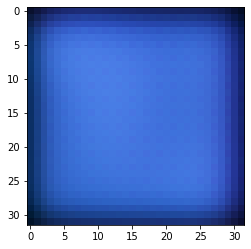

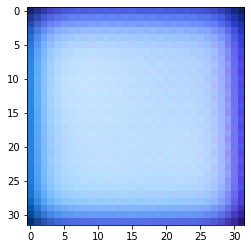

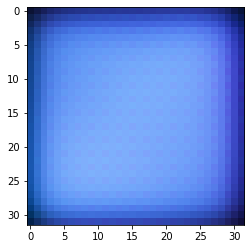

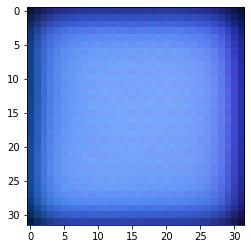

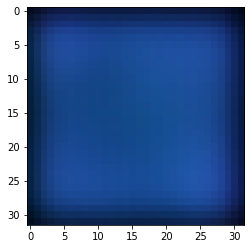

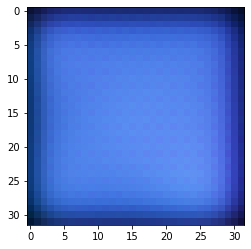

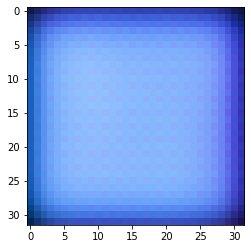

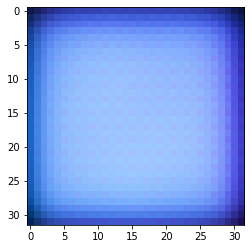

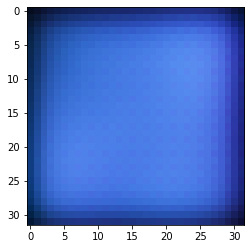

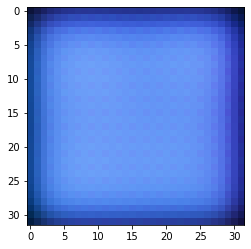

In [8]:

import matplotlib.pyplot as plt

# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

Froggy with some pixellated artifacts.

### Load and Preprocess Data

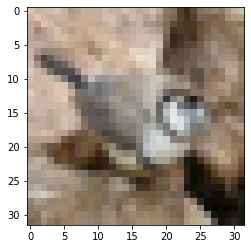

In [50]:
plt.imshow(x_train[90])

# WGAN

The following code for the WGAN was provided by this link here: https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan/wgan.py

The following code for the WGAN-GP was provided by the link here: https://github.com/keras-team/keras-contrib/blob/master/examples/improved_wgan.py

### Imports

In [1]:
# from Chollet's code
import keras
from keras import layers
import numpy as np
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt

from keras.models import load_model

import imageio

import warnings
warnings.simplefilter('ignore')

Using TensorFlow backend.


In [2]:
# from wgan
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np

In [3]:
# from wgan-gp
import argparse
import os
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers.merge import _Merge
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.datasets import mnist
from keras import backend as K
from functools import partial
from PIL import Image

### WGAN Implementation

In [23]:
class WGAN_Base():
    def __init__(self, img_height=32, img_width=32, img_channels=3):
        self.img_height = img_height
        self.img_width = img_width
        self.img_channels = img_channels
        self.img_shape = (self.img_height, self.img_width, self.img_channels)
        self.latent_dim = 100
        self.sample_interval = 10
        self.data = None
        
        # initialize the generator and discriminator
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
        # model variables
        self.generator_model = None
        self.discriminator_model = None
    
    
    def build_generator(self):
        """Creates a generator model that takes a 100-dimensional noise vector as a "seed",
        and outputs images of size img_height x img_width x img_channels."""
        model = Sequential()
        model.add(Dense(1024, input_dim=100))
        model.add(LeakyReLU())
        model.add(Dense(128 * 8 * 8))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        if K.image_data_format() == 'channels_first':
            model.add(Reshape((128, 8, 8), input_shape=(128 * 8 * 8,)))
            bn_axis = 1
        else:
            model.add(Reshape((8, 8, 128), input_shape=(128 * 8 * 8,)))
            bn_axis = -1
        model.add(Conv2DTranspose(128, (5, 5), strides=2, padding='same'))
        model.add(BatchNormalization(axis=bn_axis))
        model.add(LeakyReLU())
        model.add(Convolution2D(64, (5, 5), padding='same'))
        model.add(BatchNormalization(axis=bn_axis))
        model.add(LeakyReLU())
        model.add(Conv2DTranspose(64, (5, 5), strides=2, padding='same'))
        model.add(BatchNormalization(axis=bn_axis))
        model.add(LeakyReLU())
        # Because we normalized training inputs to lie in the range [-1, 1],
        # the tanh function should be used for the output of the generator to ensure
        # its output also lies in this range.
        model.add(Convolution2D(3, (5, 5), padding='same', activation='tanh'))
        return model
    
    
    def build_discriminator(self):
        """Creates a discriminator model that takes an image as input and outputs a single
        value, representing whether the input is real or generated. Unlike normal GANs, the
        output is not sigmoid and does not represent a probability! Instead, the output
        should be as large and negative as possible for generated inputs and as large and
        positive as possible for real inputs.
        Note that the improved WGAN paper suggests that BatchNormalization should not be
        used in the discriminator."""
        model = Sequential()
        if K.image_data_format() == 'channels_first':
            img_shape = (self.img_channels, self.img_height, self.img_width)
        else:
            img_shape = self.img_shape
        model.add(Convolution2D(64, (5, 5), padding='same', input_shape=img_shape))
        model.add(LeakyReLU())
        model.add(Convolution2D(128, (5, 5), kernel_initializer='he_normal', padding='same',
                                strides=[2, 2]))
        model.add(LeakyReLU())
        model.add(Convolution2D(128, (5, 5), kernel_initializer='he_normal', padding='same',
                                strides=[2, 2]))
        model.add(LeakyReLU())
        model.add(Flatten())
        model.add(Dense(1024, kernel_initializer='he_normal'))
        model.add(LeakyReLU())
        model.add(Dense(1, kernel_initializer='he_normal'))
        return model
    
    
    def wasserstein_loss(self, y_true, y_pred):
        """Calculates the Wasserstein loss for a sample batch."""
        return K.mean(y_true * y_pred)
    
    
    def load_cifar10_frog_data(self):
        (X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

        # select frog images (class 6)
        X_train = X_train[y_train.flatten() == 6]
        X_test = X_test[y_test.flatten() == 6]
        
        # add training and testing data together
        X_train = np.concatenate((X_train, X_test), axis=0)
        
        self.load_data(X_train)
    
    
    def load_data(self, data):
        # reshape data
        self.data = data.reshape(
            (data.shape[0],) + (self.img_height, self.img_width, self.img_channels))
        
        # normalize data to the range [-1, 1]
        self.data = (self.data.astype(np.float32) - 127.5) / 127.5
        
        
    def save_models(self, generator_model_path, discriminator_model_path):
        self.generator_model.save(generator_model_path)
        self.discriminator_model.save(discriminator_model_path)
        
        
    def tile_images(self, image_stack):
        """Given a stacked tensor of images, reshapes them into a horizontal tiling for
        display."""
        assert len(image_stack.shape) == 4
        image_list = [image_stack[i] for i in range(image_stack.shape[0])]
        tiled_images = np.concatenate(image_list, axis=1)
        return tiled_images


    def generate_images(self, output_dir='data/images', output_file='out.png', 
                        epoch=None, num_of_stacked_images=1, isWriting=False):
        """Feeds random seeds into the generator and tiles and saves the output to a PNG
        file."""
        test_image_stack = self.generator.predict(np.random.rand(num_of_stacked_images, 100))
        test_image_stack = (test_image_stack * 127.5) + 127.5
        test_image_stack = np.round(test_image_stack).astype(np.uint8)
        tiled_output = self.tile_images(test_image_stack)
        if epoch is None:
            outfile = os.path.join(output_dir, output_file)
        else:
            outfile = os.path.join(output_dir, 'epoch_{}.png'.format(epoch))
        if isWriting:
            imageio.imwrite(outfile, tiled_output)
        return tiled_output
    

In [24]:
base = WGAN_Base()

g = base.build_generator()
g.summary()

d = base.build_discriminator()
d.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 1024)              103424    
_________________________________________________________________
leaky_re_lu_145 (LeakyReLU)  (None, 1024)              0         
_________________________________________________________________
dense_66 (Dense)             (None, 8192)              8396800   
_________________________________________________________________
batch_normalization_65 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_146 (LeakyReLU)  (None, 8192)              0         
_________________________________________________________________
reshape_17 (Reshape)         (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_33 (Conv2DT (None, 16, 16, 128)     

In [25]:
class WGAN(WGAN_Base):
    def __init__(self, img_height=32, img_width=32, img_channels=3):
        super().__init__(img_height, img_width, img_channels)
        
        # Following parameters and optimizer set as recommended in paper
        self.clip_value = 0.01
        self.optimizer = RMSprop(lr=0.00005)
        self.training_ratio = 5 # number of discriminator updates per generator update
        
    def load_models(self, generator_model_path, discriminator_model_path):
        custom_objects = {'wasserstein_loss': self.wasserstein_loss}
        
        self.generator_model = load_model(generator_model_path, 
                                          custom_objects=custom_objects)
        self.discriminator_model = load_model(discriminator_model_path, 
                                              custom_objects=custom_objects)
    
    
    def train(self, epochs, batch_size=32, sample_interval=50):
        
        # The generator_model is used when we want to train the generator layers.
        # As such, we ensure that the discriminator layers are not trainable.
        # Note that once we compile this model, updating .trainable will have no effect within
        # it. As such, it won't cause problems if we later set discriminator.trainable = True
        # for the discriminator_model, as long as we compile the generator_model first.
        for layer in self.discriminator.layers:
            layer.trainable = False
        self.discriminator.trainable = False
        generator_input = Input(shape=(100,))
        generator_layers = self.generator(generator_input)
        discriminator_layers_for_generator = self.discriminator(generator_layers)
        self.generator_model = Model(inputs=[generator_input],
                                outputs=[discriminator_layers_for_generator])
        # We use the RMSprop paramaters from Gulrajani et al.
        self.generator_model.compile(optimizer=self.optimizer,
                                loss=self.wasserstein_loss)

        # Now that the generator_model is compiled, we can make the discriminator
        # layers trainable.
        for layer in self.discriminator.layers:
            layer.trainable = True
        for layer in self.generator.layers:
            layer.trainable = False
        self.discriminator.trainable = True
        self.generator.trainable = False

        # The discriminator_model is more complex. It takes both real image samples and random
        # noise seeds as input. The noise seed is run through the generator model to get
        # generated images. Both real and generated images are then run through the
        # discriminator. Although we could concatenate the real and generated images into a
        # single tensor, we don't (see model compilation for why).
        real_samples = Input(shape=self.data.shape[1:])
        generator_input_for_discriminator = Input(shape=(100,))
        generated_samples_for_discriminator = self.generator(generator_input_for_discriminator)
        discriminator_output_from_generator = self.discriminator(generated_samples_for_discriminator)
        discriminator_output_from_real_samples = self.discriminator(real_samples)

        # If we don't concatenate the real and generated samples, however, we get three
        # outputs: One of the generated samples, one of the real samples, and one of the
        # averaged samples, all of size batch_size. This works neatly!
        self.discriminator_model = Model(inputs=[real_samples,
                                                 generator_input_for_discriminator],
                                         outputs=[discriminator_output_from_real_samples,
                                                  discriminator_output_from_generator])
        # We use the RMSprop paramaters from Gulrajani et al. We use the Wasserstein loss for both
        # the real and generated samples, and the gradient penalty loss for the averaged samples
        self.discriminator_model.compile(optimizer=self.optimizer,
                                         loss=[self.wasserstein_loss,
                                               self.wasserstein_loss])
        # We make three label vectors for training. positive_y is the label vector for real
        # samples, with value 1. negative_y is the label vector for generated samples, with
        # value -1. The dummy_y vector is passed to the gradient_penalty loss function and
        # is not used.
        positive_y = np.ones((batch_size, 1), dtype=np.float32)
        negative_y = -positive_y

        for epoch in range(epochs):
            np.random.shuffle(self.data)
            print("Epoch: ", epoch)
            print("Number of batches: ", int(self.data.shape[0] // batch_size))
            discriminator_loss = []
            generator_loss = []
            minibatches_size = batch_size * self.training_ratio
            for i in range(int(self.data.shape[0] // (batch_size * self.training_ratio))):
                discriminator_minibatches = self.data[i * minibatches_size:
                                                    (i + 1) * minibatches_size]
                for j in range(self.training_ratio):
                    image_batch = discriminator_minibatches[j * batch_size:
                                                            (j + 1) * batch_size]
                    noise = np.random.rand(batch_size, 100).astype(np.float32)
                    discriminator_loss.append(self.discriminator_model.train_on_batch(
                        [image_batch, noise],
                        [positive_y, negative_y]))
                    
                    # Clip discriminator weights
                    for l in self.discriminator_model.layers:
                        weights = l.get_weights()
                        weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                        l.set_weights(weights)
                    
                generator_loss.append(self.generator_model.train_on_batch(np.random.rand(batch_size, 100),
                                                                          positive_y))

            # If at save interval => save generated image samples
            if epoch % self.sample_interval == 0: 
                self.generate_images(epoch=epoch, num_of_stacked_images=10, isWriting=True)
            
            

In [26]:
wgan = WGAN()
wgan.load_cifar10_frog_data()
wgan.train(epochs=4000)

generator_model_path = 'data/models/wgan_generator_model.h5'
discriminator_model_path = 'data/models/wgan_discriminator_model.h5'
wgan.save_models(generator_model_path, discriminator_model_path)

Epoch:  0
Number of batches:  187


FailedPreconditionError:  Error while reading resource variable _AnonymousVar842 from Container: localhost. This could mean that the variable was uninitialized. Not found: Resource localhost/_AnonymousVar842/N10tensorflow3VarE does not exist.
	 [[node mul_282/ReadVariableOp (defined at /Users/WillLacey/opt/anaconda3/envs/default/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_39668]

Function call stack:
keras_scratch_graph


In [12]:
generator_model_path = 'data/models/wgan_generator_model.h5'
discriminator_model_path = 'data/models/wgan_discriminator_model.h5'

wgan = WGAN()
wgan.load_models(generator_model_path, discriminator_model_path)

img = wgan.generate_images()
plt.imshow(img)

NameError: name 'WGAN' is not defined

In [8]:
class WGAN_GP(WGAN_Base):
    def __init__(self, img_height=32, img_width=32, img_channels=3):
        super().__init__(img_height, img_width, img_channels)
        
        # Following parameters and optimizer set as recommended in paper
        self.clip_value = 0.01
        self.optimizer = Adam(0.0001, beta_1=0.5, beta_2=0.9)
        self.training_ratio = 5 # number of discriminator updates per generator update
        self.gradient_penalty_weight = 10
        
    def load_models(self, generator_model_path, discriminator_model_path):
        custom_objects = {'wasserstein_loss': self.wasserstein_loss,
                          'RandomWeightedAverage': self.RandomWeightedAverage,
                          'gradient_penalty': self.gradient_penalty_loss
                          }
        
        self.generator_model = load_model(generator_model_path, 
                                          custom_objects=custom_objects)
        self.discriminator_model = load_model(discriminator_model_path, 
                                              custom_objects=custom_objects)
        
    class RandomWeightedAverage(_Merge):
        """Takes a randomly-weighted average of two tensors. In geometric terms, this
        outputs a random point on the line between each pair of input points.
        Inheriting from _Merge is a little messy but it was the quickest solution I could
        think of. Improvements appreciated."""

        def _merge_function(self, inputs):
            weights = K.random_uniform((32, 1, 1, 1))
            return (weights * inputs[0]) + ((1 - weights) * inputs[1])
        
        
    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples,
                              gradient_penalty_weight):
        """Calculates the gradient penalty loss for a batch of "averaged" samples.
        In Improved WGANs, the 1-Lipschitz constraint is enforced by adding a term to the
        loss function that penalizes the network if the gradient norm moves away from 1.
        However, it is impossible to evaluate this function at all points in the input
        space. The compromise used in the paper is to choose random points on the lines
        between real and generated samples, and check the gradients at these points. Note
        that it is the gradient w.r.t. the input averaged samples, not the weights of the
        discriminator, that we're penalizing!
        In order to evaluate the gradients, we must first run samples through the generator
        and evaluate the loss. Then we get the gradients of the discriminator w.r.t. the
        input averaged samples. The l2 norm and penalty can then be calculated for this
        gradient.
        Note that this loss function requires the original averaged samples as input, but
        Keras only supports passing y_true and y_pred to loss functions. To get around this,
        we make a partial() of the function with the averaged_samples argument, and use that
        for model training."""
        # first get the gradients:
        #   assuming: - that y_pred has dimensions (batch_size, 1)
        #             - averaged_samples has dimensions (batch_size, nbr_features)
        # gradients afterwards has dimension (batch_size, nbr_features), basically
        # a list of nbr_features-dimensional gradient vectors
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = gradient_penalty_weight * K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)
    
    
#     def gradient_penalty_loss2(self, y_true, y_pred):
#         """Calculates loss"""
#         real_samples = Input(shape=self.data.shape[1:])
#         generator_input_for_discriminator = Input(shape=(100,))
#         generated_samples_for_discriminator = self.generator(generator_input_for_discriminator)
#         averaged_samples = self.RandomWeightedAverage()([real_samples, 
#                                                          generated_samples_for_discriminator])
#         # first get the gradients:
#         #   assuming: - that y_pred has dimensions (batch_size, 1)
#         #             - averaged_samples has dimensions (batch_size, nbr_features)
#         # gradients afterwards has dimension (batch_size, nbr_features), basically
#         # a list of nbr_features-dimensional gradient vectors
#         gradients = K.gradients(y_pred, averaged_samples)[0]
#         # compute the euclidean norm by squaring ...
#         gradients_sqr = K.square(gradients)
#         #   ... summing over the rows ...
#         gradients_sqr_sum = K.sum(gradients_sqr,
#                                   axis=np.arange(1, len(gradients_sqr.shape)))
#         #   ... and sqrt
#         gradient_l2_norm = K.sqrt(gradients_sqr_sum)
#         # compute lambda * (1 - ||grad||)^2 still for each single sample
#         gradient_penalty = self.gradient_penalty_weight * K.square(1 - gradient_l2_norm)
#         # return the mean as loss over all the batch samples
#         return K.mean(gradient_penalty)
    
    
    def train(self, epochs, batch_size=32, sample_interval=50):
        
        # The generator_model is used when we want to train the generator layers.
        # As such, we ensure that the discriminator layers are not trainable.
        # Note that once we compile this model, updating .trainable will have no effect within
        # it. As such, it won't cause problems if we later set discriminator.trainable = True
        # for the discriminator_model, as long as we compile the generator_model first.
        for layer in self.discriminator.layers:
            layer.trainable = False
        self.discriminator.trainable = False
        generator_input = Input(shape=(100,))
        generator_layers = self.generator(generator_input)
        discriminator_layers_for_generator = self.discriminator(generator_layers)
        self.generator_model = Model(inputs=[generator_input],
                                outputs=[discriminator_layers_for_generator])
        # We use the Adam paramaters from Gulrajani et al.
        self.generator_model.compile(optimizer=self.optimizer,
                                loss=self.wasserstein_loss)

        # Now that the generator_model is compiled, we can make the discriminator
        # layers trainable.
        for layer in self.discriminator.layers:
            layer.trainable = True
        for layer in self.generator.layers:
            layer.trainable = False
        self.discriminator.trainable = True
        self.generator.trainable = False

        # The discriminator_model is more complex. It takes both real image samples and random
        # noise seeds as input. The noise seed is run through the generator model to get
        # generated images. Both real and generated images are then run through the
        # discriminator. Although we could concatenate the real and generated images into a
        # single tensor, we don't (see model compilation for why).
        real_samples = Input(shape=self.data.shape[1:])
        generator_input_for_discriminator = Input(shape=(100,))
        generated_samples_for_discriminator = self.generator(generator_input_for_discriminator)
        discriminator_output_from_generator = self.discriminator(generated_samples_for_discriminator)
        discriminator_output_from_real_samples = self.discriminator(real_samples)
        
        # We also need to generate weighted-averages of real and generated samples,
        # to use for the gradient norm penalty.
        averaged_samples = self.RandomWeightedAverage()([real_samples, 
                                                         generated_samples_for_discriminator])

        # We then run these samples through the discriminator as well. Note that we never
        # really use the discriminator output for these samples - we're only running them to
        # get the gradient norm for the gradient penalty loss.
        averaged_samples_out = self.discriminator(averaged_samples)

        # The gradient penalty loss function requires the input averaged samples to get
        # gradients. However, Keras loss functions can only have two arguments, y_true and
        # y_pred. We get around this by making a partial() of the function with the averaged
        # samples here.
        partial_gp_loss = partial(self.gradient_penalty_loss,
                                  averaged_samples=averaged_samples,
                                  gradient_penalty_weight=self.gradient_penalty_weight)
        # Functions need names or Keras will throw an error
        partial_gp_loss.__name__ = 'gradient_penalty'

        # Keras requires that inputs and outputs have the same number of samples. This is why
        # we didn't concatenate the real samples and generated samples before passing them to
        # the discriminator: If we had, it would create an output with 2 * batch_size samples,
        # while the output of the "averaged" samples for gradient penalty
        # would have only batch_size samples.

        # If we don't concatenate the real and generated samples, however, we get three
        # outputs: One of the generated samples, one of the real samples, and one of the
        # averaged samples, all of size batch_size. This works neatly!
        self.discriminator_model = Model(inputs=[real_samples,
                                                 generator_input_for_discriminator],
                                         outputs=[discriminator_output_from_real_samples,
                                                  discriminator_output_from_generator, 
                                                  averaged_samples_out])
        # We use the Adam paramaters from Gulrajani et al. We use the Wasserstein loss for both
        # the real and generated samples, and the gradient penalty loss for the averaged samples
        self.discriminator_model.compile(optimizer=self.optimizer,
                                         loss=[self.wasserstein_loss,
                                               self.wasserstein_loss,
                                               partial_gp_loss])
        # We make three label vectors for training. positive_y is the label vector for real
        # samples, with value 1. negative_y is the label vector for generated samples, with
        # value -1. The dummy_y vector is passed to the gradient_penalty loss function and
        # is not used.
        positive_y = np.ones((batch_size, 1), dtype=np.float32)
        negative_y = -positive_y
        dummy_y = np.zeros((batch_size, 1), dtype=np.float32)

        for epoch in range(epochs):
            np.random.shuffle(self.data)
            print("Epoch: ", epoch)
            print("Number of batches: ", int(self.data.shape[0] // batch_size))
            discriminator_loss = []
            generator_loss = []
            minibatches_size = batch_size * self.training_ratio
            for i in range(int(self.data.shape[0] // (batch_size * self.training_ratio))):
                discriminator_minibatches = self.data[i * minibatches_size:
                                                    (i + 1) * minibatches_size]
                for j in range(self.training_ratio):
                    image_batch = discriminator_minibatches[j * batch_size:
                                                            (j + 1) * batch_size]
                    noise = np.random.rand(batch_size, 100).astype(np.float32)
                    discriminator_loss.append(self.discriminator_model.train_on_batch(
                        [image_batch, noise],
                        [positive_y, negative_y, dummy_y]))
                generator_loss.append(self.generator_model.train_on_batch(np.random.rand(batch_size, 100),
                                                                          positive_y))

            # If at save interval => save generated image samples
            if epoch % self.sample_interval == 0: 
                self.generate_images(epoch=epoch, num_of_stacked_images=10, isWriting=True)
            

In [9]:
wgan_gp = WGAN_GP()
wgan_gp.load_cifar10_frog_data()
wgan_gp.train(epochs=4000)

generator_model_path = 'data/models/wgan_gp_generator_model.h5'
discriminator_model_path = 'data/models/wgan_gp_discriminator_model.h5'
wgan_gp.save_models(generator_model_path, discriminator_model_path)

Epoch:  0
Number of batches:  187


FailedPreconditionError:  Error while reading resource variable _AnonymousVar181 from Container: localhost. This could mean that the variable was uninitialized. Not found: Resource localhost/_AnonymousVar181/N10tensorflow3VarE does not exist.
	 [[node mul_3/ReadVariableOp (defined at /Users/WillLacey/opt/anaconda3/envs/default/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_7295]

Function call stack:
keras_scratch_graph


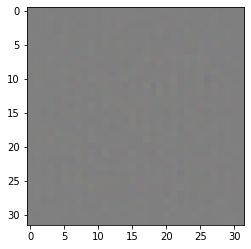

In [15]:
generator_model_path = 'data/models/wgan_gp_generator_model.h5'
discriminator_model_path = 'data/models/wgan_gp_generator_model.h5'

wgan_gp = WGAN_GP()
wgan_gp.load_models(generator_model_path, discriminator_model_path)

img = wgan_gp.generate_images()
plt.imshow(img)